Manufactured Solution experiment based on SAND2000 - 1444

Test based on [CHiMaD Phase Field Benchmark Problem 7](https://pages.nist.gov/pfhub/benchmarks/benchmark7.ipynb)

In [1]:
%matplotlib inline

In [2]:
import fipy as fp

# symbolic form

In [3]:
from sympy import Symbol, symbols, simplify, init_printing
from sympy import Eq, sin, cos, tanh, sqrt, pi
from sympy.printing import pprint
from sympy.abc import kappa, S, t, x, xi, y, alpha

from sympy.physics.vector import ReferenceFrame, dynamicsymbols, time_derivative, divergence, gradient
N = ReferenceFrame('N')
t = symbols('t')

init_printing(use_unicode=True)

# alpha = symbols('a')
A1, A2 = symbols('A1 A2')
B1, B2 = symbols('B1 B2')
C2 = symbols('C2')

# Define interface offset (alpha)
alpha = 0.25 + A1 * t * sin(B1 * N[0]) + A2 * sin(B2 * N[0] + C2 * t)

# Define the solution equation (eta)
xi = (N[1] - alpha) / sqrt(2*kappa)
eta_sol = (1 - tanh(xi)) / 2

In [5]:
eq_sym = simplify(time_derivative(eta_sol, N)
                  + 4 * eta_sol * (eta_sol - 1) * (eta_sol - 0.5) 
                  - divergence(kappa * gradient(eta_sol, N), N))

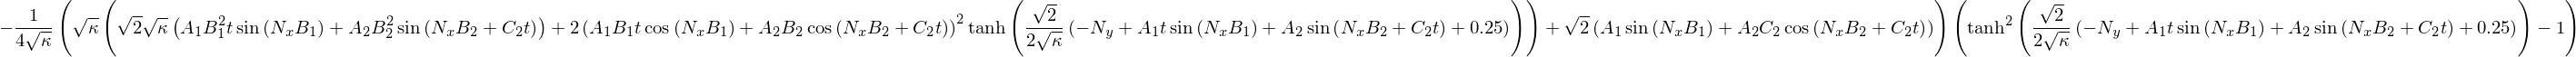

In [6]:
eq_sym

# substitute coefficient values

In [7]:
parameters = ((kappa, 0.0004), 
              (A1, 0.0075), (B1, 8.0 * pi), 
              (A2, 0.03), (B2, 22.0 * pi), 
              (C2, 0.0625 * pi))

In [9]:
subs = [sub.subs(parameters) for sub in (eq_sym, eta_sol)]

# generate FiPy lambda functions

In [63]:
from sympy.utilities.lambdify import lambdify, lambdastr

In [64]:
(eq_fp, eta_fp) = [lambdify((N[0], N[1], t), sub, modules=fp.numerix) for sub in subs]

In [65]:
kappa_fp = float(kappa.subs(parameters))

# order in space

In [14]:
factor = 2.

In [15]:
grid_spacing = 0.01 * factor**fp.numerix.arange(0, -4, -1)

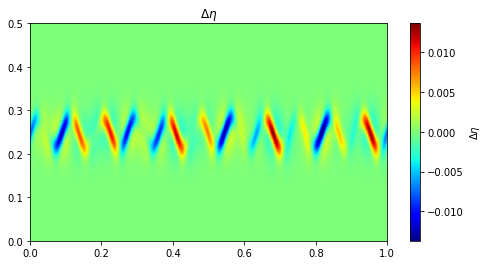

KeyboardInterrupt: 

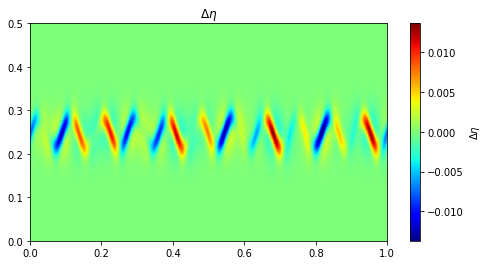

In [32]:
dt = 0.1
dx = 0.001

nx = int(1. / dx)
ny = int(0.5 / dx)

mesh = fp.PeriodicGrid2DLeftRight(nx=nx, dx=dx, ny=ny, dy=dx)
xx, yy = mesh.cellCenters[0], mesh.cellCenters[1]
XX, YY = mesh.faceCenters[0], mesh.faceCenters[1]

time = fp.Variable(name="$t$", value=0.)

eta = fp.CellVariable(mesh=mesh, name=r"$\eta$", hasOld=True)
eta.constrain(1., where=YY==0.)
eta.constrain(0., where=YY==0.5)

eta.value = eta_fp(xx, yy, 0.)

deta = eta - eta_fp(xx, yy, time)
deta.name = r"$\Delta\eta$"

viewer = fp.Viewer(vars=deta)

eq = (fp.TransientTerm() == 
      - 4 * eta * (eta - 1) * (eta - 0.5) 
      + fp.DiffusionTerm(coeff=kappa_fp) + eq_fp(xx, yy, time))

while time.value <= 8.0:
    eta.updateOld()
    eq.solve(var=eta, dt=dt)
    time.value = time() + dt
    viewer.plot()

In [54]:
num_cells = 100 * factor**fp.numerix.arange(0, 4)

In [58]:
etaerror2 = []
etaerrorINF = []

In [59]:
dt = 1e-2
Lx = 1.
Ly = 0.5

for nx in num_cells:
    ny = int(nx * Ly / Lx)
    dx = Lx / nx
    dy = Ly / ny
    
    mesh = fp.PeriodicGrid2DLeftRight(nx=nx, dx=dx, ny=ny, dy=dx)
    xx, yy = mesh.cellCenters[0], mesh.cellCenters[1]
    XX, YY = mesh.faceCenters[0], mesh.faceCenters[1]

    time = fp.Variable(name="$t$", value=0.)

    eta = fp.CellVariable(mesh=mesh, name="$eta$", hasOld=True)
    eta.constrain(1., where=YY==0.)
    eta.constrain(0., where=YY==0.5)

    eta.value = eta_fp(xx, yy, 0.)
    
    eq = (fp.TransientTerm() == 
          - 4 * eta * (eta - 1) * (eta - 0.5) 
          + fp.DiffusionTerm(coeff=kappa_fp) + eq_fp(xx, yy, time))
    
    while time.value <= 8.0:
        eta.updateOld()
        eq.solve(var=eta, dt=dt)
        time.value = time() + dt
        
    deta = eta - eta_fp(xx, yy, time - dt)
    
    etaerror2.append(fp.numerix.L2norm(deta * mesh.cellVolumes) / fp.numerix.L2norm(mesh.cellVolumes))
    etaerrorINF.append(fp.numerix.LINFnorm(deta))
    
    print dx, etaerror2[-1], etaerrorINF[-1]

0.01 0.00951052015068 0.0909811142631
0.005 0.00192878555885 0.013687999818
0.0025 0.000460896826561 0.0032378183703
0.00125 0.000175645770579 0.00147188198137


In [49]:
from matplotlib import pyplot as plt

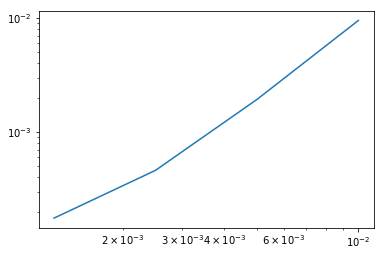

In [62]:
plt.loglog(Lx / num_cells, etaerror2) #, Lx / num_cells, etaerrorINF)

In [ ]:
Terror2 = fp.numerix.array(Terror2)
TerrorINF = fp.numerix.array(TerrorINF)

In [ ]:
fp.numerix.log(Terror2[:-1] / Terror2[1:]) / fp.numerix.log(factor) - 2.

In [ ]:
fp.numerix.log(TerrorINF[:-1] / TerrorINF[1:]) / fp.numerix.log(factor) - 2.

# order in time

In [ ]:
factor = 2.

In [ ]:
time_step = 1. * factor**fp.numerix.arange(0, -12, -1)

In [ ]:
Terror2 = []
Terror2plus = []
Terror2minus = []
TerrorINF = []

In [ ]:
dx = 0.5
for dt in time_step:
    mesh = fp.Grid2D(Lx=10., dx=dx, Ly=20., dy=dx)
    xx, yy = mesh.cellCenters[0], mesh.cellCenters[1]
    XX, YY = mesh.faceCenters[0], mesh.faceCenters[1]

    time = fp.Variable(name="$t$", value=0.)

    T = fp.CellVariable(mesh=mesh, name="$T$", hasOld=True)
    T.value = T_fp(xx, yy, 0.)*0.01
    T.constrain(T_fp(XX, YY, time), where=mesh.exteriorFaces)
    
    eq = (fp.DiffusionTerm(coeff=k_fp(XX, YY, time)) + g_fp(xx, yy, time)
          == fp.TransientTerm(coeff=rho_fp(xx, yy, time) * Cp_fp(xx, yy, time)))
    
    while time.value <= 2.0:
        T.updateOld()
        time.value = time() + dt
        eq.solve(var=T, dt=dt)
        
    dT = T - T_fp(xx, yy, time)
    dTplus = T - T_fp(xx, yy, time + dt)
    dTminus = T - T_fp(xx, yy, time - dt)

    Terror2.append(fp.numerix.L2norm(dT * mesh.cellVolumes) / fp.numerix.L2norm(mesh.cellVolumes))
    Terror2plus.append(fp.numerix.L2norm(dTplus * mesh.cellVolumes) / fp.numerix.L2norm(mesh.cellVolumes))
    Terror2minus.append(fp.numerix.L2norm(dTminus * mesh.cellVolumes) / fp.numerix.L2norm(mesh.cellVolumes))
    TerrorINF.append(fp.numerix.LINFnorm(dT))
    
    print dt, Terror2[-1], TerrorINF[-1]

In [ ]:
Terror2 = fp.numerix.array(Terror2)
TerrorINF = fp.numerix.array(TerrorINF)

In [ ]:
fp.numerix.log(Terror2[:-1] / Terror2[1:]) / fp.numerix.log(factor)

In [ ]:
fp.numerix.log(TerrorINF[:-1] / TerrorINF[1:]) / fp.numerix.log(factor)

In [ ]:
Terror2plus = fp.numerix.array(Terror2plus)
fp.numerix.log(Terror2plus[:-1] / Terror2plus[1:]) / fp.numerix.log(factor)

In [ ]:
Terror2minus = fp.numerix.array(Terror2minus)
fp.numerix.log(Terror2minus[:-1] / Terror2minus[1:]) / fp.numerix.log(factor)